This notebook generates the images related to the synthetic elections generated by Mallows Models.

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import cluster
from sklearn.metrics import silhouette_score

import sys
sys.path.append('..')
from Clustering_Functions import *

In [2]:
def Sil_scores(election, num_cands='Auto'):
    """
    returns the silhouette score of the k-means clustering of the given election for k=2,3,4,5.

    Returns: dictionary of silhouette scores for k=2,3,4,5 
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    X = np.array([Borda_vector(ballot, num_cands=num_cands) for ballot in election.keys()])
    sample_weight = np.array([election[ballot] for ballot in election.keys()])

    sil_scores = dict()
    for k in range(2,6):
        kmeans = cluster.KMeans(n_clusters=k, n_init = 200).fit(X,sample_weight=sample_weight)
        labels = kmeans.labels_
        sil_scores[k] = (silhouette_score(X,labels))   
    return sil_scores

In [7]:
# The 5-candidate election, E, from section 4 of the paper
E, C_truth = Mallows_election(5, 2, [(1,2,3,4,5), (5,4,3,2,1)], [300, 700], .3)

Cm, medoids = kmedoids(E, k=2, return_medoids=True)
print(f"PAM: medoids = {medoids}, sizes = {[sum(Cm[i].values()) for i in range(len(Cm))]}")
Cl = kmeans(E, k=2)
print(f"K-means: sizes = {[sum(Cl[i].values()) for i in range(len(Cl))]}")
slates, Cs = Slate_cluster(E, k=2, return_slates=True)
print(f"Slate-based: slates = {slates}, sizes = {[sum(Cs[i].values()) for i in range(len(Cs))]}")

c:\Users\ktapp\Documents\Python\ballot-clustering\.venv\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureWarning)


PAM: medoids = [(5, 4, 3, 2, 1), (1, 2, 3, 4, 5)], sizes = [684.0, 316.0]
K-means: sizes = [683, 317]
Slate-based: slates = [{1, 2, 3}, {4, 5}], sizes = [314.0, 686.0]


In [4]:
print("distances to Lloyd")
c = Clustering_closeness(E, Cl, Cm)
print(f"PAM: {c}")
c = Clustering_closeness(E, Cl, Cs)
print(f"Slate-based: {c}")

distances to Lloyd
PAM: 0.01
Slate-based: 0.0365


In [8]:
# The three elections E1, E2, E3 from section 4 of the paper
def E_Mal(n,p):
    """
    Returns the En election with p value p.
    """
    if n == 1:
        return Mallows_election(num_cands=9, num_clusters=1, centers=[[1,2,3,4,5,6,7,8,9]], sizes=[1000], p=p)
    elif n == 2:
        return Mallows_election(num_cands=9, num_clusters=2, 
                                centers=[[1,2,3,4,5,6,7,8,9], [8,7,5,9,6,3,2,1,4]], 
                                sizes=[300, 700], p=p)
    elif n == 3:
        return Mallows_election(num_cands=9, num_clusters=3, 
                                centers=[[1,2,3,4,5,6,7,8,9], [4,6,5,1,8,2,7,3,9], [7,8,9,4,5,6,3,2,1]],
                                sizes=[200, 200, 600], p=p)

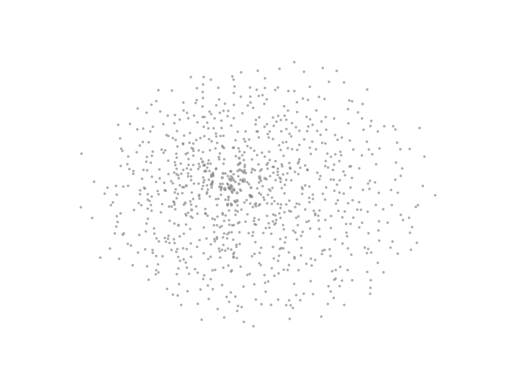

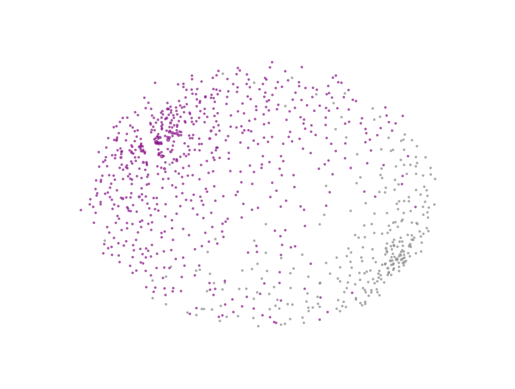

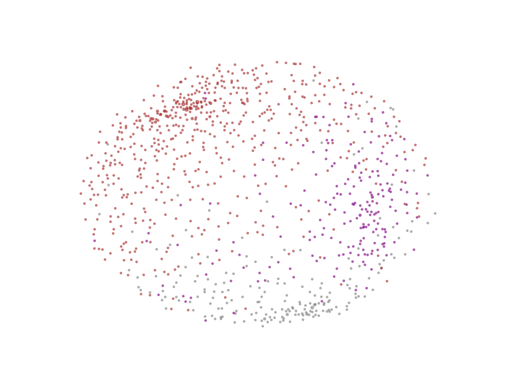

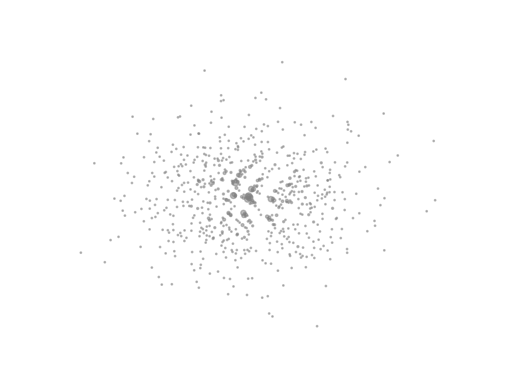

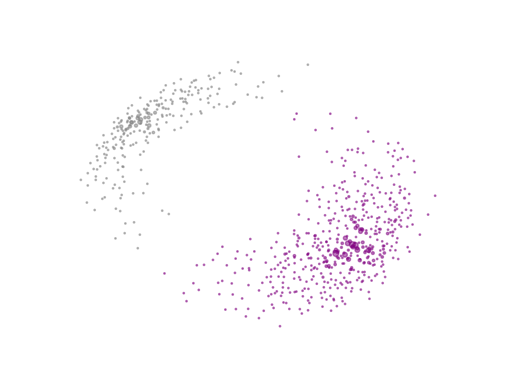

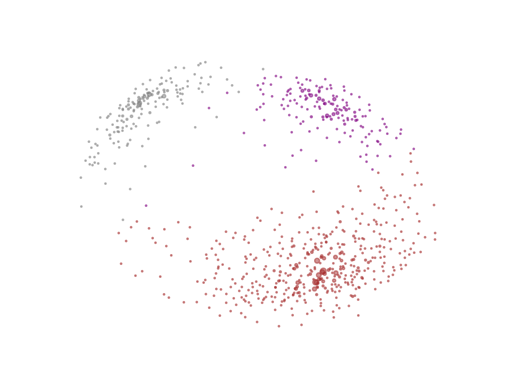

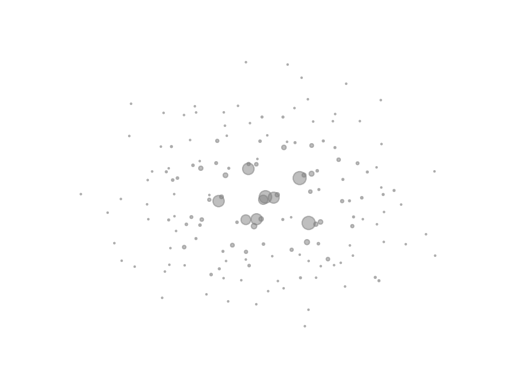

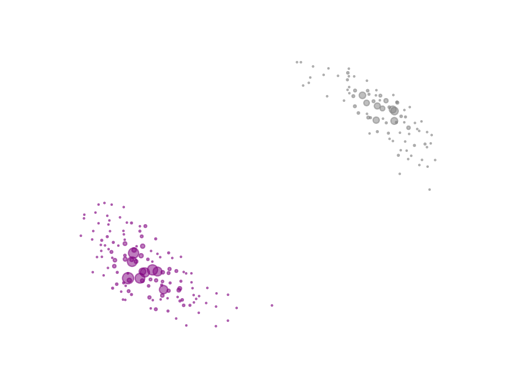

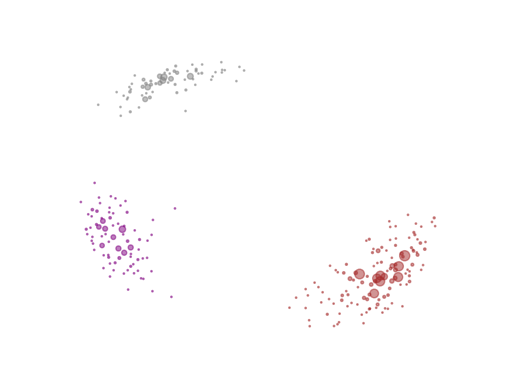

In [4]:
# display MDS plots a high (p=0.02) middle (p=.1) and low dispersion (p=.5) cases
for p in [0.02, .1, 0.5]:
    for n in [1,2,3]:
        E, C = E_Mal(n,p)
        Ballot_MDS_plot(E, C, threshold = 1, filename=f'E{n}_p{int(p*100)}.png')

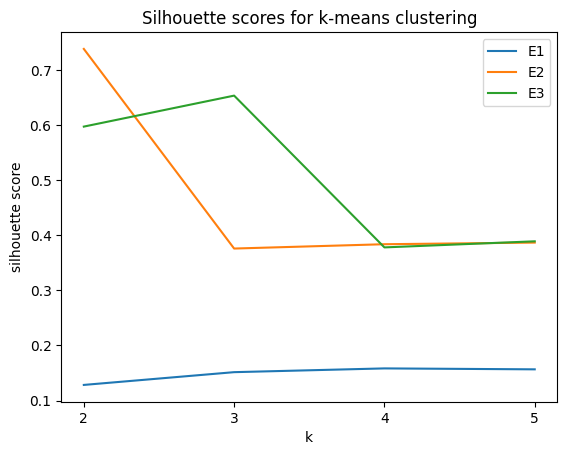

In [6]:
# Study the p=.5 case
S1 = Sil_scores(E_Mal(1,0.5)[0])
S2 = Sil_scores(E_Mal(2,0.5)[0])
S3 = Sil_scores(E_Mal(3,0.5)[0])

p_range = [2, 3, 4, 5]
plt.plot(p_range, [S1[k] for k in p_range], label='E1')
plt.plot(p_range, [S2[k] for k in p_range], label='E2')
plt.plot(p_range, [S3[k] for k in p_range], label='E3')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette scores for k-means clustering')
plt.legend()
plt.xticks(p_range)
plt.savefig('Silhouette_vs_k.jpg', dpi = 300)
plt.show()

In [16]:
# Next study the E2 and E3 elections with different p values
p_range = np.arange(.02,.5,.02)
sil_E2 = [] # silhouette scores for E2 elections with different p values
#medoids_E2 = dict() # dictionary mapping p values to the PAM 2-centers of the E2 elections

for p in p_range:
    election, C_truth = E_Mal(2,p)
#    C_PAM, C_medoids = kmedoids(election, k=2, return_medoids=True)
    sil_scores = Sil_scores(election)
    sil_E2.append(sil_scores)
#    medoids_E2[p] = C_medoids

p_range = np.arange(.02,.5,.02)
sil_E3 = [] # silhouette scores for E3 elections with different p values
#medoids_E3 = dict()  # dictionary mapping p values to the PAM 3-centers of the E3 elections

for p in p_range:
    election, C_truth = E_Mal(3,p)
#    C_PAM, C_medoids = kmedoids(election, k=3, return_medoids=True)
    sil_scores = Sil_scores(election)
    sil_E3.append(sil_scores)
#    medoids_E3[p] = C_medoids

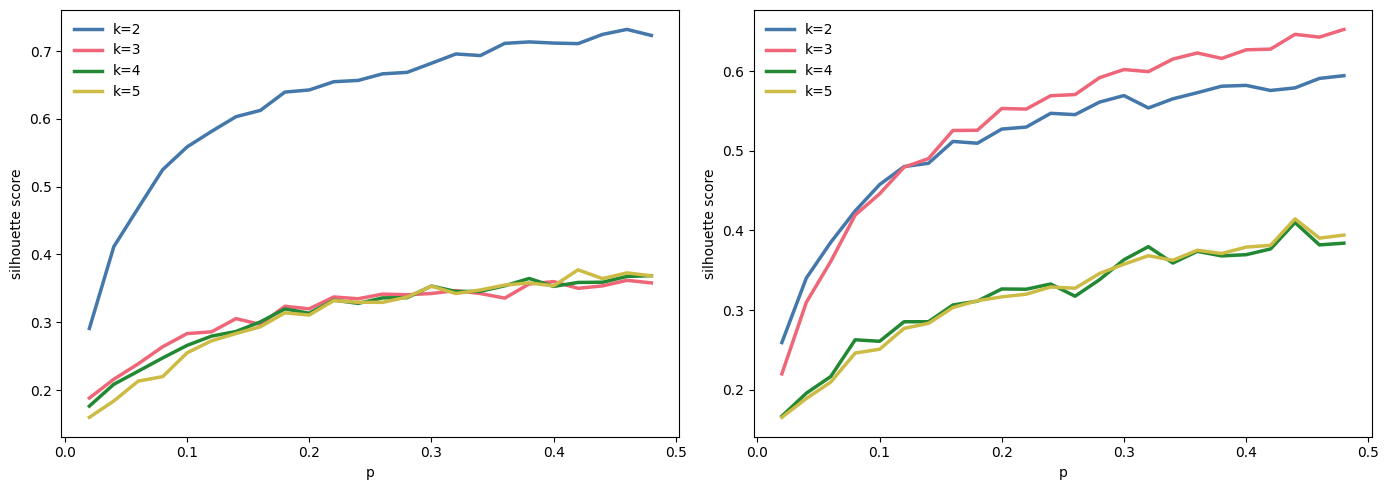

In [18]:
# Display the Silhouette plots of E2 and E3 side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Choose a better 4-color palette (colorblind-friendly)
colors = [
    "#4477AA",  # blue
    "#EE6677",  # red
    "#228833",  # green
    "#CCBB44",  # yellow
]
line_width = 2.5

# FIRST PLOT (E2)
for idx, k in enumerate(range(2, 6)):
    axs[0].plot(
        p_range,
        [sil_scores[k] for sil_scores in sil_E2],
        label=f'k={k}',
        color=colors[idx],
        linewidth=line_width
    )

axs[0].set_xlabel('p')
axs[0].set_ylabel('silhouette score')
axs[0].legend(frameon=False)

# SECOND PLOT (E3)
for idx, k in enumerate(range(2, 6)):
    axs[1].plot(
        p_range,
        [sil_scores[k] for sil_scores in sil_E3],
        label=f'k={k}',
        color=colors[idx],
        linewidth=line_width
    )

axs[1].set_xlabel('p')
axs[1].set_ylabel('silhouette score')
axs[1].legend(frameon=False)

plt.tight_layout()
plt.savefig('Sil_p.png', dpi=1200)
plt.show()

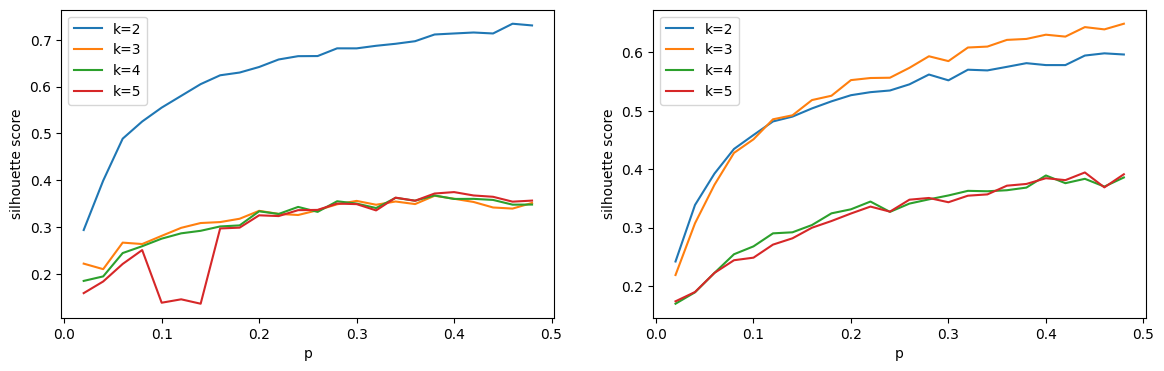

In [11]:
# Display the Silhouette plots of E2 and E3 side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# FIRST PLOT
for k in range(2, 6):
    axs[0].plot(p_range, [sil_scores[k] for sil_scores in sil_E2], label=f'k={k}')
axs[0].set_xlabel('p')
axs[0].set_ylabel('silhouette score')
#axs[0].set_title('Silhouette scores for k-means clustering of E2(p)')
axs[0].legend()

# SECOND PLOT
for k in range(2, 6):
    axs[1].plot(p_range, [sil_scores[k] for sil_scores in sil_E3], label=f'k={k}')
axs[1].set_xlabel('p')
axs[1].set_ylabel('silhouette score')
#axs[1].set_title('Silhouette scores for k-means clustering of E3(p)')
axs[1].legend()

plt.savefig('Sil_p.png', dpi = 1200)
plt.show()

In [26]:
E2_centers = centers=[[1,2,3,4,5,6,7,8,9], [8,7,5,9,6,3,2,1,4]]
E3_centers = centers=[[1,2,3,4,5,6,7,8,9], [4,6,5,1,8,2,7,3,9], [7,8,9,4,5,6,3,2,1]]

# re-order the medoids if necessary to match the given order of E2_centers and E3_centers
for p in p_range:
    medoids = medoids_E2[p]
    if HH_dist(E2_centers[1], medoids[0], 9) < HH_dist(E2_centers[0], medoids[0], 9):
        medoids_E2[p] = [medoids[1], medoids[0]] # swap the order

for p in p_range:
    medoids = medoids_E3[p]
    ind0 = np.argmin([HH_dist(E3_centers[0], medoid, 9) for medoid in medoids])
    ind1 = np.argmin([HH_dist(E3_centers[1], medoid, 9) for medoid in medoids])
    ind2 = np.argmin([HH_dist(E3_centers[2], medoid, 9) for medoid in medoids])
    if ind0 == ind1 or ind0 == ind2 or ind1 == ind2:
        raise ValueError(f'Error: medoids for p={p} are not distinct')
    medoids_E3[p] = [medoids[ind0], medoids[ind1], medoids[ind2]] # re-order the medoids

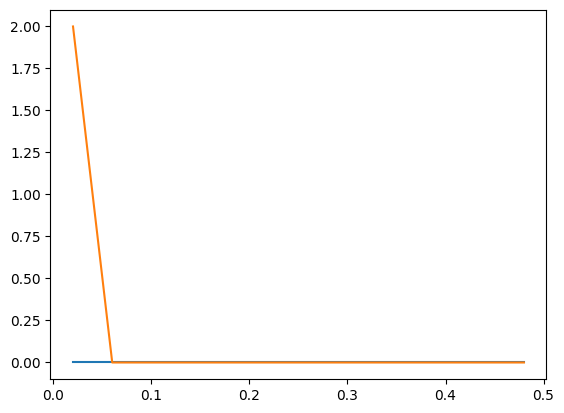

In [27]:
# measure summed distances of the medoids to the centers
dist_E2 = []
for p in p_range:
    medoids = medoids_E2[p]
    dist = HH_dist(E2_centers[0], medoids[0], 9) + HH_dist(E2_centers[1], medoids[1], 9)
    dist_E2.append(dist)
dist_E3 = []
for p in p_range:
    medoids = medoids_E3[p]
    dist = HH_dist(E3_centers[0], medoids[0], 9) + HH_dist(E3_centers[1], medoids[1], 9) + HH_dist(E3_centers[2], medoids[2], 9)
    dist_E3.append(dist)
# make the plot
plt.plot(p_range, dist_E2, label='E2')
plt.plot(p_range, dist_E3, label='E3') 

In [28]:
# Verify that the E2 centers match the medoids for all p values
print(f'E2 centers: {E2_centers}\n')

for p in p_range:
    medoids = medoids_E2[p]
    print(f'p={p:.2f} E2 medoids: {medoids}')

E2 centers: [[1, 2, 3, 4, 5, 6, 7, 8, 9], [8, 7, 5, 9, 6, 3, 2, 1, 4]]

p=0.02 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.04 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.06 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.08 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.10 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.12 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.14 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.16 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.18 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.20 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.22 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2, 1, 4)]
p=0.24 E2 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (8, 7, 5, 9, 6, 3, 2,

In [29]:
#Verify that the E3 centers match the medoids for all p values
print(f'E3 centers: {E3_centers}\n')
for p in p_range:
    medoids = medoids_E3[p]
    print(f'p={p:.2f} E3 medoids: {medoids}')

E3 centers: [[1, 2, 3, 4, 5, 6, 7, 8, 9], [4, 6, 5, 1, 8, 2, 7, 3, 9], [7, 8, 9, 4, 5, 6, 3, 2, 1]]

p=0.02 E3 medoids: [(1, 2, 3, 4, 5, 6, 7, 9, 8), (6, 4, 5, 1, 8, 2, 7, 3, 9), (7, 8, 9, 4, 5, 6, 3, 2, 1)]
p=0.04 E3 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (4, 5, 6, 1, 8, 2, 7, 3, 9), (7, 8, 9, 4, 5, 6, 3, 2, 1)]
p=0.06 E3 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (4, 6, 5, 1, 8, 2, 7, 3, 9), (7, 8, 9, 4, 5, 6, 3, 2, 1)]
p=0.08 E3 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (4, 6, 5, 1, 8, 2, 7, 3, 9), (7, 8, 9, 4, 5, 6, 3, 2, 1)]
p=0.10 E3 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (4, 6, 5, 1, 8, 2, 7, 3, 9), (7, 8, 9, 4, 5, 6, 3, 2, 1)]
p=0.12 E3 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (4, 6, 5, 1, 8, 2, 7, 3, 9), (7, 8, 9, 4, 5, 6, 3, 2, 1)]
p=0.14 E3 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (4, 6, 5, 1, 8, 2, 7, 3, 9), (7, 8, 9, 4, 5, 6, 3, 2, 1)]
p=0.16 E3 medoids: [(1, 2, 3, 4, 5, 6, 7, 8, 9), (4, 6, 5, 1, 8, 2, 7, 3, 9), (7, 8, 9, 4, 5, 6, 3, 2, 1)]
p=0.18 E3 medoids: [(1, 2, 3, 4, 5, 6, 7, 8